## Read in data

In [1]:
import pandas as pd
import numpy as np

In [2]:
oo = pd.read_csv('../data/online_retail_small.csv')

In [3]:
cd ../ddf/

/home/viknesh/NUS/artificalData/artificial-dataset-generation/ddf


In [13]:
from ddf.stainer import Stainer, RowDuplicateStainer, ColumnSplitter,ResidualResampler
from ddf.DirtyDF import DirtyDF
from numpy.random import default_rng
from time import time
rng= default_rng()

In [ ]:
d1 = oo.sample(n=4)

In [11]:
d2 = oo.sample(n=4)
d2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,1/12/2010 9:57,1.65,16029.0,United Kingdom
562,536412,22077,6 RIBBONS RUSTIC CHARM,1,1/12/2010 11:49,1.65,17920.0,United Kingdom
2755,536592,22570,FELTCRAFT CUSHION RABBIT,1,1/12/2010 17:06,7.62,NaN,United Kingdom
3106,536597,21221,SET/4 BADGES CUTE CREATURES,5,1/12/2010 17:35,1.25,18011.0,United Kingdom


## Column splitter

In [ ]:
class ColumnSplitter(Stainer):
    """ Stainer to split text columns, creating a ragged DataFrame """
    
    def __init__(self, name = "Column splitter", col_idx = [], regex_string=" "):
        """ Constructor for ColumnSplitter
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This has to be a single integer. This is 
                 the column that will be split into two.
        regex_string: The string to split the column on. For instance, "(?=-)" is a
                 look-ahead assertion that splits on a hyphen. Using lookahead or 
                 look-behind strings ensures that the splitting character is retained.
                 
                 
        Raises
        ------
        ValueError
            If col_idx is missing, or is length greater than 1.
        """
        if ((type(col_idx) is not list) or (len(col_idx) != 1)):
            raise ValueError("col_idx must be a list with a single integer.")
        super().__init__(name, [], col_idx)
        self.regex_string = regex_string
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator. Unused by this stainer.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with one extra column on the right.
        row_map : empty dictionary
            Row mapping showing the relationship between the original and new row positions.
        col_map : A dictionary
            Generating the column map is tricky in this situation, because after the split column,
            on the right, each column actually contains information from two original columns. One option 
            is to indicate which two columns each new column maps to, but, since most of the original 
            columns were retained, we only indicate that the right-most column has been mapped to the
            last two of the new dataframe.
       
        >>> rng = np.random.default_rng(12)
        >>> x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'price': [2.30, 3.20]})
        >>> print(x)
             label  price
        0  T-LIGHT    2.3
        1  ASHTRAY    3.2
        
        >>> cc = ColumnSplitter(col_idx=[0], regex_string="(?=-)")
        >>> new_x, rmap, cmap = cc.transform(x, rng)
        >>> print(new_x) # see the ragged dataframe.. it contains unnamed column on the right.
             label   price     
        0        T  -LIGHT  2.3
        1  ASHTRAY     3.2  NaN
        
        >>> print(cmap)
        {0: [0], 1: [1, 2]}
        
        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
        
        org_col_index = new_df.columns
        col_name = org_col_index[col_idx[0]]
        split_id = np.argwhere(org_col_index == col_name).reshape(1)[0]
        
        # split the original df into three sections: 
        # to_keep, col_to_split and cols_to_join_back
        to_keep = new_df.iloc[:, :split_id].copy(deep=True)
        to_split = df[[col_name]].copy(deep=True)
        to_join = df.iloc[:, (split_id+1):].copy(deep=True)
        cols_to_add = np.hstack((org_col_index[(split_id+1):], ''))
        to_join[''] = pd.Series([np.NaN]*to_join.shape[0])
        
        #split the column:
        to_split = to_split[col_name].str.split(self.regex_string, n=1, expand=True)
        to_split.columns = [col_name, cols_to_add[0]]
        
        # join the split column back first
        #to_keep = pd.concat([to_keep, to_split], axis=1)
        to_keep = to_keep.join(to_split)
        na_boolean = to_keep[cols_to_add[0]].isna()
        to_keep = to_keep.combine_first(to_join[[cols_to_add[0]]])
        #breakpoint()
        
        for i in np.arange(1,len(cols_to_add)):
            #print(i)
            new_col = to_join.iloc[:, i].copy(deep=True)
            new_col[~na_boolean] = to_join.iloc[:, i-1][~na_boolean]
            to_keep = pd.concat([to_keep, new_col], axis=1)
            #print(cols_to_add[i])
        #print(cols_to_add)
        #return to_keep[np.hstack((org_col_index, ''))]
        
        # create col-map:
        cmap = {}
        for ii in np.arange(df.shape[1]):
            cmap[ii] = [ii]
        cmap[df.shape[1]-1] = [df.shape[1]-1, df.shape[1]]
        # print(cmap)
        
        end = time()
        self.update_history(f"Column id {col_name} split into two.", end-start)
        self.update_history(message = f"New dataframe has {to_keep.shape[1]} columns now.")
        return to_keep[np.hstack((org_col_index, ''))],{},cmap

In [ ]:
import doctest
doctest.run_docstring_examples(ColumnSplitter.transform, globs=None, verbose=True)

----

In [ ]:
rng = np.random.default_rng(12)
x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'price': [2.30, 3.20]})
cc = ColumnSplitter(col_idx=[0], regex_string="(?=-)")
new_x, rmap, cmap = cc.transform(x, rng)

In [ ]:
print(new_x)

In [ ]:
print(x)

In [ ]:
print(cmap)

In [ ]:
d2

In [12]:
cc = ColumnSplitter(col_idx=[2], regex_string="(?=\/)")
cc.transform(d2, rng)

(     InvoiceNo StockCode               Description                  Quantity  \
 177     536386    85099B   JUMBO BAG RED RETROSPOT                       100   
 562     536412     22077    6 RIBBONS RUSTIC CHARM                         1   
 2755    536592     22570  FELTCRAFT CUSHION RABBIT                         1   
 3106    536597     21221                       SET  /4 BADGES CUTE CREATURES   
 
           InvoiceDate        UnitPrice  CustomerID         Country  \
 177    1/12/2010 9:57             1.65    16029.00  United Kingdom   
 562   1/12/2010 11:49             1.65    17920.00  United Kingdom   
 2755  1/12/2010 17:06             7.62         NaN  United Kingdom   
 3106              5.0  1/12/2010 17:35        1.25         18011.0   
 
                       
 177              NaN  
 562              NaN  
 2755             NaN  
 3106  United Kingdom  ,
 {},
 {0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7, 8]})

In [ ]:
d2.shape

---

In [ ]:
d2.index

In [ ]:
d2.index = np.arange(4) # this should be fixed, currently only works with 0..n-1 index
                        # not true - original indexing can be used, but the output index will be 0...(n-1)
#d2

#rr= RowDuplicateStainer(deg=1/3, name='test dup row map', row_idx=[730, 3582])
rr= RowDuplicateStainer(deg=1/3, name='test dup row map', row_idx=[0,1,2])

#ddf1 = DirtyDF(d2, seed=1)
#ddf1 = ddf1.add_stainers(rr)
#ddf2 = ddf1.run_stainer()
#ddf2.get_df()
df,rmap,colmap = rr.transform(d2, rng)

In [ ]:
rmap

In [ ]:
cmap = {}
#cmap.keys() = df.index

In [ ]:
for ii in df.index:
    cmap[ii] = [ii]

In [ ]:
cmap

In [ ]:
df

In [ ]:
rmap

In [ ]:
d2

---

In [ ]:
cc = ColumnSplitter(col_idx=[5])

In [ ]:
d2 = oo.sample(n=4)

In [ ]:
d2

In [ ]:
d2.columns

In [ ]:
# original implementation

def column_splitter(df, col_name, regex_string="(?=-)"):
    org_col_index = df.columns
    split_id = np.argwhere(org_col_index == col_name).reshape(1)[0]
    
    # split the original df into three sections: 
    # to_keep, col_to_split and cols_to_join_back
    to_keep = df.iloc[:, :split_id].copy(deep=True)
    to_split = df[[col_name]].copy(deep=True)
    to_join = df.iloc[:, (split_id+1):].copy(deep=True)
    cols_to_add = np.hstack((org_col_index[(split_id+1):], ''))
    to_join[''] = pd.Series([np.NaN]*to_join.shape[0])
    
    #split the column:
    to_split = to_split[col_name].str.split(regex_string, n=1, expand=True)
    to_split.columns = [col_name, cols_to_add[0]]
    
    # join the split column back first
    #to_keep = pd.concat([to_keep, to_split], axis=1)
    to_keep = to_keep.join(to_split)
    na_boolean = to_keep[cols_to_add[0]].isna()
    to_keep = to_keep.combine_first(to_join[[cols_to_add[0]]])
    #breakpoint()
    
    for i in np.arange(1,len(cols_to_add)):
        #print(i)
        new_col = to_join.iloc[:, i].copy(deep=True)
        new_col[~na_boolean] = to_join.iloc[:, i-1][~na_boolean]
        to_keep = pd.concat([to_keep, new_col], axis=1)
        #print(cols_to_add[i])
    #print(cols_to_add)
    
    return to_keep[np.hstack((org_col_index, ''))]

In [ ]:
column_splitter(d2, 'Description')

## Column joiner

In [ ]:
telco = pd.read_csv("../data/Telco-Customer-Churn.csv")

In [ ]:
telco_sub = telco.sample(n=10)
telco_sub

In [ ]:
d3 = telco.copy(deep=True)

d3 = d3.reindex()

In [ ]:
class ColumnJoiner(Stainer):
    """ Stainer to join text columns, creating a ragged DataFrame """
    
    def __init__(self, name = "Column splitter", row_idx =[], col_idx = []):
        """ Constructor for ColumnJoiner
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This has to contain two consecutive integers. These are 
                 the columns that will be catenated.
        row_idx: int list, required. These will be the rows that will be "shifted" inwards.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        ValueError
            If row_idx is empty.
        """
        if ((len(col_idx) != 2) or (col_idx[1] - col_idx[0] != 1)):
            raise ValueError("col_idx must contain two consecutive integers.")
        if(len(row_idx) == 0):
            raise ValueError("row_idx should not be empty.")
        super().__init__(name, row_idx, col_idx)
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator. Unused by this stainer.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with some columns shifted "inwards"
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'dept':['A1', 'A2'], 'price': [2.30, 3.20]})
        >>> print(x)
             label dept  price
        0  T-LIGHT   A1    2.3
        1  ASHTRAY   A2    3.2

        >>> cj1 = ColumnJoiner('test joiner', [1], [0,1])
        >>> print(cj1.transform(x, rng))
               label dept  price
        0    T-LIGHT   A1    2.3
        1  ASHTRAYA2  3.2    NaN
        
        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
                
        org_col_index = new_df.columns
        col_names = org_col_index[col_idx]
        
        split_id = np.argwhere(org_col_index == col_names[1]).reshape(1)[0]
        to_keep = new_df.loc[:, :col_names[0]].copy(deep=True)
        join_series = new_df[col_names[1]].copy(deep=True)
        to_join = new_df.iloc[:, split_id:].copy(deep=True)

        # breakpoint()
        # modify the column to join, and paste with to_keep
        join_series[~join_series.index.isin(row_idx)] = ''
        to_keep[col_names[0]] = to_keep[col_names[0]] + join_series
        
        for i in np.arange(split_id, new_df.shape[1]):
            # print(i)
            new_col = new_df.iloc[:, i].copy(deep=True)
            if i < (new_df.shape[1] - 1):
                new_col[row_idx] = new_df.iloc[:, i+1][row_idx]
            else:
                new_col[row_idx] = np.NaN
            to_keep = pd.concat([to_keep, new_col], axis=1)
            #breakpoint()
        
        end = time()
        self.update_history(f"Column id {col_names[0]} and {col_names[1]} joined at certain rows.", end-start)
        return to_keep,{},{}

In [ ]:
dd = ColumnJoiner('test', [1,4], [8, 9])
dd.transform(d3, rng)

In [ ]:
doctest.run_docstring_examples(dd.transform , globs=None, verbose=True)

In [ ]:
c1 = join_fn(telco_sub.MultipleLines, telco_sub.InternetService)

In [ ]:
def join_fn(v1, v2):
    return (v1 == 'No phone service') & (v2 == 'DSL')

In [ ]:
def column_joiner(df, col_name1, col_name2, join_criteria):
    # join_index should be a boolean index that indicates which rows to join.
    # use *row_idx* when we implement the stainer.
    
    org_col_index = df.columns
    split_id = np.argwhere(org_col_index == col_name2).reshape(1)[0]
    to_keep = df.loc[:, :col_name1].copy(deep=True)
    join_series = df[col_name2].copy(deep=True)
    to_join = df.iloc[:, split_id:].copy(deep=True)
    
    # breakpoint()
    # modify the column to join, and paste with to_keep
    join_series[~join_criteria] = ''
    to_keep[col_name1] = to_keep[col_name1] + join_series
    
    for i in np.arange(split_id, df.shape[1]):
        # print(i)
        new_col = df.iloc[:, i].copy(deep=True)
        if i < (df.shape[1] - 1):
            new_col[join_criteria] = df.iloc[:, i+1][join_criteria]
        else:
            new_col[join_criteria] = np.NaN
        to_keep = pd.concat([to_keep, new_col], axis=1)
        #breakpoint()

    return to_keep

In [ ]:
out = column_joiner(telco_sub, 'MultipleLines', 'InternetService', c1)

In [ ]:
telco_sub.loc[:, 'MultipleLines':]

---

## Resample residuals

In [ ]:
from statsmodels.regression.linear_model import OLS, WLS
from statsmodels.tools import add_constant
from ddf.samplers import rand_from_Finv

In [ ]:
class ResidualResampler(Stainer):
    """ Stainer to resample residuals from a linear model and return new y's. """
    
    def __init__(self, name = "Residual resampler", row_idx =[], col_idx = []):
        """ Constructor for ResidualResampler
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This should specify at least two columns. The first will
                 be used as the y-variable, and the others will be used as the X matrix.
        row_idx: int list, unused.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        """
        if len(col_idx) < 2:
            raise ValueError("col_idx must contain at least two integers.")
        super().__init__(name, row_idx, col_idx)
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        A ordinary least squares linear model is fit, using statsmodels. The residuals are then
        sampled from using rand_from_Finv (from ddf.samplers) and added back to the fitted y-hats
        to create a new set of y-values.
        
        This stainer should result in a similar fit, but slightly different diagnostics/statistics.
        
        The user should check if the new y-values are valid or not (e.g. are they negative when they 
        shouldn't be?)
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with some columns shifted "inwards"
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = np.arange(1, 11)
        >>> y = x*2.3 + 3 + rng.normal(scale=1.6, size=10)
        >>> org_df = pd.DataFrame({'x':x, 'y':y})

        >>> rr = ResidualResampler('test rr', [], [1,0])
        >>> new_df = rr.transform(org_df, rng)

        >>> print(pd.concat((org_df, new_df), axis=1))
            x          y   x          y
        0   1   5.289077   1   4.155549
        1   2   9.273829   2   8.747416
        2   3  11.086541   3   8.444612
        3   4  13.358330   4  11.250526
        4   5  17.090042   5  14.005535
        5   6  14.871107   6  16.610120
        6   7  18.096871   7  18.940797
        7   8  19.286939   8  23.466323
        8   9  23.527596   9  21.974412
        9  10  27.598022  10  23.545538

        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
        
        # drop missing values
        col_names = new_df.columns[col_idx]
        fit_df = new_df.iloc[:, col_idx].dropna()
        
        X = add_constant(fit_df.iloc[:, 1:])
        y = fit_df.iloc[:,0]
    
        # fit and predict from the model
        m = OLS(y, X)
        o = m.fit()
        new_resid = rand_from_Finv(o.resid, rng, size=len(o.resid))
        new_y = o.predict(X) + new_resid
        
        # only put new values where we could predict values; otherwise keep old y-values.
        new_df.loc[y.index, col_names[0]] = new_y
        
        end = time()
        self.update_history(f"New y-values in column {col_idx[0]} by sampling from residual distribution.", 
                            end-start)
        return new_df,{},{}

In [ ]:
rr = ResidualResampler('test rr', [], [5, 19])
rr.transform(telco, rng).head()

In [15]:
rng = np.random.default_rng(12)
x = np.arange(1, 11)
y = x*2.3 + 3 + rng.normal(scale=1.6, size=10)
org_df = pd.DataFrame({'x':x, 'y':y})

In [18]:
rr = ResidualResampler('test rr', [], [1,0])
new_df = rr.transform(org_df, rng)[0]

In [17]:
new_df

(    x          y
 0   1   4.155549
 1   2   8.747416
 2   3   8.444612
 3   4  11.250526
 4   5  14.005535
 5   6  16.610120
 6   7  18.940797
 7   8  23.466323
 8   9  21.974412
 9  10  23.545538,
 {},
 {})

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

print(pd.concat((org_df, new_df), axis=1))

    x          y   x          y
0   1   5.289077   1   6.891292
1   2   9.273829   2  10.673205
2   3  11.086541   3  12.731433
3   4  13.358330   4  14.541629
4   5  17.090042   5  12.720387
5   6  14.871107   6  19.215727
6   7  18.096871   7  19.722592
7   8  19.286939   8  22.994630
8   9  23.527596   9  22.492393
9  10  27.598022  10  23.678673


<AxesSubplot:xlabel='x', ylabel='y'>

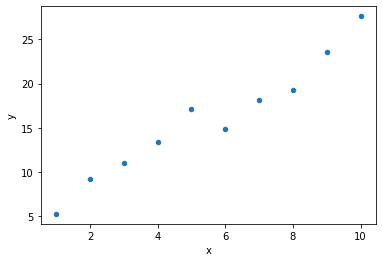

In [23]:
org_df.plot(x='x', y='y', kind='scatter')

<AxesSubplot:xlabel='x', ylabel='y'>

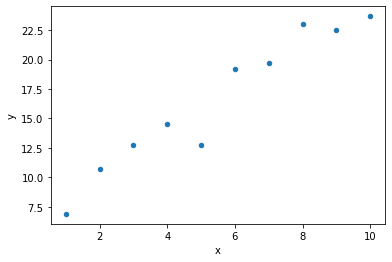

In [24]:
new_df.plot(x='x', y='y', kind='scatter')

In [ ]:
plt.scatter(x,y)

In [ ]:
x

In [ ]:
telco.tenure.describe()

In [ ]:
x = pd.DataFrame({'label': ['T-LIGHT', 'ASHTRAY'], 'dept':['A1', 'A2'], 'price': [2.30, 3.20]})

In [ ]:
rand_from_Finv?

In [ ]:
telco.info()

In [ ]:
x.iloc[:,0]

In [ ]:
from scipy.interpolate import Akima1DInterpolator
from statsmodels.distributions.empirical_distribution import ECDF

def rand_from_Finv(X, size=(1,10), Xmin=None, Xmax = None):
    rvs_needed = np.array(size).prod()
    ecdf1 = ECDF(X)
    U = np.hstack((0.0, ecdf1.y[1:-1], 1.0))
    
    if Xmin is None:
        Xmin = X.min()
    if Xmax is None:
        Xmax = X.max()
        
    Finv = np.hstack((Xmin, ecdf1.x[1:-1], Xmax))
    ak2 = Akima1DInterpolator(U, Finv)

    U_rand = np.random.uniform(size=rvs_needed)
    out = ak2(U_rand).reshape(size)
    return out

In [ ]:
def resample_residuals(df, ycol, Xcols):
    breakpoint()
    new_df = df.dropna()
    X = add_constant(new_df[[Xcols]])
    y = new_df[ycol]
    
    #drop_these = pd.isna(X.TotalCharges)
    #X = X[~drop_these]
    #y = y[~drop_these]
    
    m = OLS(y, X)
    o = m.fit()
    new_resid = rand_from_Finv(o.resid, rng, size=len(o.resid))
    
    #df[ycol] = o.predict(X) + new_resid
    
    return df

In [ ]:
resample_residuals(telco, 'tenure', 'TotalCharges').info()

---

## Insert outlier to influential point

In [ ]:
#from statsmodels.stats.outliers_influence import *

In [ ]:
class InsertOutliers(Stainer):
    """ Stainer to insert outliers at influential points using a linear model. """
    
    def __init__(self, name = "Inserts outliers", row_idx =[], col_idx = [], n=5):
        """ Constructor for InsertOutliers
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This should specify at least two columns. The first will
                 be used as the y-variable, and the others will be used as the X matrix.
        row_idx: int list, unused.
        n:       number of outliers to insert. The default is 5.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        """
        if len(col_idx) < 2:
            raise ValueError("col_idx must contain at least two integers.")
        super().__init__(name, row_idx, col_idx)
        self.n = n
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        A ordinary least squares linear model is fit, using statsmodels. 
        
        The 5 most influential points are identified (using their leverage).
        
        The residuals for these 5 points are replaced by sampling from the 5% tails of the residual 
        distributions.
        
        This stainer should result in a similar fit, but slightly different diagnostics/statistics.
        
        The user should check if the new y-values are valid or not (e.g. are they negative when they 
        shouldn't be?)
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
            Modified dataframe, with some columns shifted "inwards"
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = np.arange(1, 11)
        >>> x[-2:] = [15,16]

        >>> y = x*2 + 3 + rng.normal(scale=5, size=10)
        >>> org_df = pd.DataFrame({'x':x, 'y':y})

        >>> rr = InsertOutliers('test rr', [], [1,0], n=2)
        >>> new_df = rr.transform(org_df, rng)[0]

        >>> print(pd.concat((org_df, new_df), axis=1))
            x          y   x          y
        0   1   4.965866   1   4.965866
        1   2  12.230716   2  12.230716
        2   3  12.707942   3  12.707942
        3   4  14.619783   4  14.619783
        4   5  21.093881   5  21.093881
        5   6   8.972209   6   8.972209
        6   7  13.865223   7  13.865223
        7   8  12.396684   8  12.396684
        8  15  32.461237  15  39.217787
        9  16  39.993818  16  27.541544

        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()
        
        # drop missing values
        col_names = new_df.columns[col_idx]
        fit_df = new_df.iloc[:, col_idx].dropna()
        
        X = add_constant(fit_df.iloc[:, 1:])
        y = fit_df.iloc[:,0]
    
        # obtain a function to sample from residuals
        m = OLS(y, X)
        o = m.fit()
        Finv = rand_from_Finv(o.resid, rng, return_fn=True)
        
        # derive leverage
        hhh4 = pd.Series(np.diag(np.matmul(np.matmul(X.values, 
                                                     np.linalg.inv(np.matmul(np.transpose(X.values), X.values))), 
                                           np.transpose(X.values))))
        hhh4.index = X.index
        replace_these = hhh4.nlargest(self.n).index
        
        # sample from tails
        V = rng.random(size=self.n)
        W = [rng.uniform(0.0, 0.05,1)[0] if (x <= 0.5) else rng.uniform(0.95, 1.00, 1)[0] for x in V ]
        
        # only put new values where we could predict values; otherwise keep old y-values.
        new_y = o.predict(X.loc[replace_these,:]) + Finv(W)
        #f2 = df.copy(deep=True)
        new_df.loc[replace_these, col_names[0]] = new_y        
        
        end = time()
        self.update_history(f"Outliers in column {col_idx[0]} by sampling from residual distribution.", 
                            end-start)
        return new_df,{},{}

In [ ]:
rng = np.random.default_rng(12)
x = np.arange(1, 11)
x[-2:] = [15,16]

y = x*2 + 3 + rng.normal(scale=5, size=10)
org_df = pd.DataFrame({'x':x, 'y':y})

#org_df.plot('x', 'y', kind='scatter');

rr = InsertOutliers('test rr', [], [1,0], n=2)
new_df = rr.transform(org_df, rng)[0]

#import matplotlib.pyplot as plt
#%matplotlib inline

print(pd.concat((org_df, new_df), axis=1))

In [ ]:
new_df.plot('x', 'y', kind='scatter')

In [ ]:
def insert_outlier(df, ycol, Xcols, n=5):
    X = add_constant(df[[Xcols]])
    drop_these = pd.isna(X.TotalCharges)
    X = X[~drop_these]
    hhh4 = pd.Series(np.diag(np.matmul(np.matmul(X.values, 
                                                 np.linalg.inv(np.matmul(np.transpose(X.values), X.values))), 
                                       np.transpose(X.values))))
    hhh4.index = X.index
    replace_these = hhh4.nlargest(n).index
    
    y = df[ycol]
    y = y[~drop_these]
    m = OLS(y, X)
    o = m.fit()
    r1 = o.resid

    ecdf1 = ECDF(r1)
    Finv = np.hstack((r1.min(), ecdf1.x[1:-1], r1.max()))
    U = np.hstack((0.0, ecdf1.y[1:-1], 1.0))
    ak2 = Akima1DInterpolator(U, Finv)
    
    V = np.random.random(n)
    W = [np.random.uniform(0.0, 0.05,1)[0] if (x <= 0.5) else np.random.uniform(0.95, 1.00, 1)[0] for x in V ]
    
    new_y = o.predict(X.loc[replace_these,:]) + ak2(W)
    df2 = df.copy(deep=True)
    
    df2.loc[replace_these, ycol] = new_y
    return df2

---

## Modify Correlation

In [ ]:
from scipy.stats import spearmanr,pearsonr,norm

In [ ]:
class ModifyCorrelation(Stainer):
    """ Stainer to modify correlation between two columns. """
    
    def __init__(self, name = "Inserts outliers", row_idx =[], col_idx = [], rho=None):
        """ Constructor for ModifyCorrelation
        
        Parameters
        ----------
        name: str, optional.
            Name of stainer. 
        col_idx: int list, required. This should specify exactly two numeric columns.
        row_idx: int list, unused.
        rho:     New correlation between the two columns.
                 
        Raises
        ------
        ValueError
            If col_idx has length not equals to two, or the values are not consecutive.
        """
        if len(col_idx) != 2:
            raise ValueError("col_idx must contain exactly two integers.")
        if rho is None:
            raise ValueError("rho needs to specified.")
        super().__init__(name, row_idx, col_idx)
        self.rho = rho
        
    def transform(self, df, rng, row_idx=None, col_idx=None):
        """Applies staining on the given indices in the provided dataframe.
        
        A multivariate normal copula is used, with the Finv being fitted using the Akima interpolator.
        
        Parameters
        ----------
        df : pd.DataFrame 
            Dataframe to be transformed.
        rng : np.random.BitGenerator
            PCG64 pseudo-random number generator.
        row_idx : int list, optional
            Unused parameter.
        col_idx : int list, optional
            Unused parameter.
        
        Returns
        -------
        new_df : pd.DataFrame
        row_map : empty dictionary.
        col_map : empty dictionary.
       
        >>> rng = np.random.default_rng(12)
        >>> x = np.arange(0, 100)
        >>> y = x*2 + 3 + rng.normal(scale=25, size=100)
        >>> org_df = pd.DataFrame({'x':x, 'y':y})
        >>> spearmanr(org_df.x, org_df.y)[0]
        0.9324692469246924

        >>> rr = ModifyCorrelation('test rr', [], [1,0], rho=0.0)
        >>> new_df = rr.transform(org_df, rng)[0]
        >>> spearmanr(new_df.x, new_df.y)[0]
        0.12897689768976897
        """
        new_df, row_idx, col_idx = self._init_transform(df, row_idx, col_idx)
        start = time()

        # drop missing values
        col_names = new_df.columns[col_idx]
        fit_df = new_df.iloc[:, col_idx].dropna()
        
        # estimate Finv, Ginv
        X1 = fit_df.iloc[:, 0]
        Finv = rand_from_Finv(X1, rng, return_fn=True)
        X2 = fit_df.iloc[:, 1]
        Ginv = rand_from_Finv(X2, rng, return_fn=True)
        
        org_corr = spearmanr(X1, X2)[0]

        # sample multivariate normal with desired correlation
        mu = np.zeros(2)
        sigma = np.ones((2,2))
        sigma[0,1] = sigma[1,0] = self.rho
        Xn = rng.multivariate_normal(mu, sigma, size=new_df.shape[0], method='cholesky')

        # apply norm cdf to array
        Yn = norm.cdf(Xn)

        # apply Finv, Ginv
        new_col1 = Finv(Yn[:,0])
        new_col2 = Ginv(Yn[:,1])
        new_df.loc[:, col_names[0]] = new_col1
        new_df.loc[:, col_names[1]] = new_col2
        
        end = time()
        self.update_history(f"Correlation modified from {org_corr:.2f} to {self.rho:.2f}.", end-start)
        return new_df,{},{}

In [ ]:
mm = ModifyCorrelation('test1', col_idx=[5,19], rho=-0.2)

In [ ]:
tmp = mm.transform(telco, rng)

In [ ]:
spearmanr(tmp.tenure, tmp.TotalCharges)

In [ ]:
rng = np.random.default_rng(12)
x = np.arange(0, 100)
y = x*2 + 3 + rng.normal(scale=25, size=100)
org_df = pd.DataFrame({'x':x, 'y':y})

spearmanr(org_df.x, org_df.y)[0]

In [ ]:
org_df.plot('x', 'y', kind='scatter')

In [ ]:
#org_df.plot('x', 'y', kind='scatter');

rr = ModifyCorrelation('test rr', [], [1,0], rho=0.0)
new_df = rr.transform(org_df, rng)[0]

#print(pd.concat((org_df, new_df), axis=1))

spearmanr(new_df.x, new_df.y)[0]

In [ ]:
new_df.plot('x', 'y', kind='scatter')

In [ ]:
def modify_correlation(df, col1, col2, rho):
    # estimate/interpolate cdf for col1 and col2
    ecdf1 = ECDF(df[col1])
    Finv_step = np.hstack((df[col1].min(), ecdf1.x[1:-1], df[col1].max()))
    U = np.hstack((0.0, ecdf1.y[1:-1], 1.0))
    Finv = Akima1DInterpolator(U, Finv_step)

    ecdf2 = ECDF(df[col2])
    Ginv_step = np.hstack((df[col2].min(), ecdf2.x[1:-1], df[col2].max()))
    U = np.hstack((0.0, ecdf2.y[1:-1], 1.0))
    Ginv = Akima1DInterpolator(U, Ginv_step)
    
    # print original correlation
    org_corr = spearmanr(df[col1], df[col2])
    #print(f'The original spearman correlation is {org_corr[0]:.2f}.')
    
    # sample multivariate normal with desired correlation
    rng = default_rng()
    mu = np.zeros(2)
    sigma = np.ones((2,2))
    sigma[0,1] = sigma[1,0] = rho
    Xn = rng.multivariate_normal(mu, sigma, size=df.shape[0], method='cholesky')
    
    # apply norm cdf to array
    Yn = norm.cdf(Xn)
    
    # apply Finv, Ginv
    new_col1 = Finv(Yn[:,0])
    new_col2 = Ginv(Yn[:,1])
    
    df2 = df.copy(deep=True)
    df2[col1] = new_col1
    df2[col2] = new_col2
    
    # return df
    return df2

In [ ]:
telco.tenure.describe()

In [ ]:
X = telco[['TotalCharges']]
y = telco.tenure
X = add_constant(X)

In [ ]:
hhh4 = pd.Series(np.diag(np.matmul(np.matmul(X.values, np.linalg.inv(np.matmul(np.transpose(X.values), X.values))), np.transpose(X.values))))

In [ ]:
hhh4.tail()

In [ ]:
hhh.tail()

In [ ]:
drop_these = pd.isna(X.TotalCharges)
X = X[~drop_these]
y = y[~drop_these]

In [ ]:
m = OLS(y, X)

o = m.fit()

In [ ]:
(y - (o.predict(X) + o.resid)).sum()

rand_from_Finv(o.resid, size=len(o.resid)).shape

In [ ]:
y.shape

In [ ]:
telco.head()

In [ ]:
out['MultipleLines'] + out['OnlineBackup']

In [ ]:
out.shape

In [ ]:
tmp[['Description', 'InvoiceNo']]

In [ ]:
tmp

In [ ]:
pdb.runcall(column_splitter, d2, 'Description')

In [ ]:
tmp.iloc[:, 5]

In [ ]:
pd.DataFrame.combine_first?

In [ ]:
id = pd.Series([True, False, False, True])

In [ ]:
id.index = qty_series.index

In [ ]:
qty_series[id] = d2.Description[id]

In [ ]:
qty_series

In [ ]:
d2a = d2.Description.str.split('-',n=1, expand=True)

In [ ]:
d2a[[1]]

In [ ]:
d2[["Quantity"]]

In [ ]:
d2.combine_first?

In [ ]:
pd.concat([d2a[[1]],d2[["Quantity"]]], axis=1)

In [ ]:
oo.Description.str.contains("[^\w\s]", regex=True).isna().sum()

In [ ]:
oo2 = oo[~oo.Description.isna()]

In [ ]:
tmp = oo2[oo2.Description.str.contains("[^\w\s]", regex=True)].Description

In [ ]:
tmp.str.split("(?=-)",n=1, expand=True)